<a href="https://colab.research.google.com/github/Famasmili/WAS/blob/School_Work/Rb_IFT6135_A2_LSTM_LSTMv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
'''
All the imports
'''

import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import logging
import time
import random
import wandb
import os

# Dataset Generator (Do not modify)

In [3]:
def torch_copying_data(
    L,
    M,
    A,
    batch_shape=(),
):
    """
    Generate a dataset for a selective copying task.

    Parameters:
    L (int): Number of noise tokens
    M (int): Number of tokens to memorize
    A (int): Vocab size
    batch_shape (tuple): Shape of the batch


    Returns:
    tuple: Generated input sequence and target sequence
    """
    tokens = torch.randint(low=1, high=A - 1, size=batch_shape + (M,))
    total_batch = int(np.prod(batch_shape))
    inds = torch.stack([torch.randperm(L + M)[:M] for _ in range(total_batch)], 0)
    inds = inds.reshape(batch_shape + (M,))
    inds, _ = inds.sort()
    zeros_x = torch.zeros(batch_shape + (M + L,), dtype=torch.long)
    zeros_x.scatter_(-1, inds, tokens)
    markers = (A - 1) * torch.ones(batch_shape + (M,), dtype=torch.long)

    x_ = torch.cat([zeros_x, markers], dim=-1)
    y_ = torch.cat([tokens], dim=-1)
    return x_, y_


def generate_dataset(args):
    """
    Generate a dataset based on the provided configuration.

    Parameters:
    args: Arguments for data generation

    Returns:
    tuple: Generated inputs and targets
    """
    x, y = torch_copying_data(
        args.l_noise, args.l_memorize, args.l_vocab, batch_shape=(args.batch_size,)
    )
    return x, y

# LSTM

In [4]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        """
        Initialize the weight matrix here.

        """
        self.weight_matrix = nn.Linear(input_size + hidden_size, 4 * hidden_size) # Write code here
        self.init_params()

        # We will use layer norm in the forward function for stable training
        self.layer_norm = nn.LayerNorm(hidden_size)

    def init_params(self):
        nn.init.xavier_uniform_(self.weight_matrix.weight)
        self.weight_matrix.bias = nn.Parameter(
            torch.zeros_like(self.weight_matrix.bias)
        )

    def compute_gates_and_candidate_cell_state(self, x, h):
        """
        x: (batch_size, input_size)

        Returns the i, f, the candidate hidden state tilde(c) and o

        (Refer to the assignment document for the notations)

        Each of the four is expected to be of shape (batch_size, hidden_size)
        Make sure to apply suitable activation functions as described in the assignment
        """
        # Write code here
        # Concatenate input and hidden state
        combined = torch.cat((x, h), dim=1)
        # Compute gates and candidate cell state
        gates = self.weight_matrix(combined)
        gate_chunks = torch.chunk(gates, 4, dim=1)
        input_gate = torch.sigmoid(gate_chunks[0])
        forget_gate = torch.sigmoid(gate_chunks[1])
        candidate_cell_state = torch.tanh(gate_chunks[2])
        output_gate = torch.sigmoid(gate_chunks[3])

        #i, f, o, g = torch.split(gates, gates.size(1) // 4, dim=1)
        #i = torch.sigmoid(i)
        #f = torch.sigmoid(f)
        #o = torch.sigmoid(o)
        #g = torch.tanh(g)
        return input_gate, forget_gate, candidate_cell_state, output_gate

    def forward(self, x, h, c):
        """
        x: (batch_size, input_size)

        Returns the next computed hidden and cell state (h_next, c_next)

        (Refer to the assignment document for the notations)

        Each of the two is expected to be of shape (batch_size, hidden_size)

        IMPORTANT: Apply the layer norm (initialized in __init__) to the c_next in the calculation
        of h_next before applying the tanh activation
        """
        # Write code here
        h_next = torch.zeros_like(h)
        c_next = torch.zeros_like(c)
        input_gate, forget_gate, candidate_cell_state, output_gate = self.compute_gates_and_candidate_cell_state(x, h)
        c_next = torch.addcmul(forget_gate * c, input_gate, candidate_cell_state)
        normalized_c_next = self.layer_norm(c_next)
        h_next = output_gate * torch.tanh(normalized_c_next)
        return h_next, c_next


In [5]:
class LSTM(nn.Module):
    def __init__(self, embed_dim, hidden_size, n_layers, vocab_size, mem_len):
        """
        DO NOT MODIFY
        """
        super().__init__()
        self.embed_dim = embed_dim
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size  # l_vocab
        self.mem_len = mem_len  # l_memorize
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.cells = nn.ModuleList(
            [LSTMCell(embed_dim, hidden_size)]
            + [LSTMCell(hidden_size, hidden_size) for _ in range(n_layers - 1)]
        )
        self.clf = nn.Linear(embed_dim, vocab_size, bias=False)
        self.out_mlp = nn.Sequential(
            nn.Linear(hidden_size, embed_dim), nn.ReLU(), self.clf
        )
        self.clf.weight = self.embedding.weight

    def get_model_hidden_states(self, x):
        """
        x: (batch_size, sequence_length, embedding_dim)

        Returns the output hidden states, with output taken from the last l_memorize steps.
        Make sure the code is general and works with multiple stacked layers of LSTM. The initial
        hidden and cell states should be initialized to all zeros.

        (Refer to the assignment document for the notations and explanation)

        Output is expected to be of shape (batch_size, l_memorize, hidden_size)
        """

        batch_size = x.size(0)
        seq_length = x.size(1)

        final_hidden_states = []
        hidden_states = [torch.zeros(batch_size, self.hidden_size).to(x.device) for _ in range(self.n_layers)]
        cell_states = [torch.zeros(batch_size, self.hidden_size).to(x.device) for _ in range(self.n_layers)]
        for i in range(seq_length):
            input = x[:, i, :]

            for j in range(self.n_layers):
                hidden_states[j], cell_states[j] = self.cells[j](input, hidden_states[j], cell_states[j])
                input = hidden_states[j]
            if i >= x.size(1) - self.mem_len: # Only take the last l_memorize steps
                final_hidden_states.append(hidden_states[-1])

        return torch.stack(final_hidden_states, dim=1)
        pass

    def forward(self, x):
        """
        x: (batch_size, sequence_length)

        Returns unnormalized logits as output, with output corresponding to last l_memorize steps.

        You should only use the provided methods.

        (Refer to the assignment document for the notations and explanation)

        Output is expected to be of shape (batch_size, l_memorize, l_vocab)
        """

        x_embedded = self.embedding(x) # (batch_size, sequence_length, embedding_dim) Embedding
        hidden_states = self.get_model_hidden_states(x_embedded)
        logits = self.out_mlp(hidden_states)
        return logits


# LSTMv2

In [6]:
class LSTMv2Cell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        """
        Initialize the weight matrix here
        """
        self.hidden_size = hidden_size
        self.weight_matrix = nn.Linear(input_size, 3 * hidden_size)  # Write code here

        self.init_params()

    def init_params(self):
        nn.init.xavier_uniform_(self.weight_matrix.weight)
        self.weight_matrix.bias = nn.Parameter(
            torch.zeros_like(self.weight_matrix.bias)
        )

    def compute_gates_and_candidate_hidden_state(self, x):
        """
        x: (batch_size, sequence_length, input_size)

        Returns the i, f and the candidate hidden state tilde(h)

        (Refer to the assignment document for the notations)

        Each of the three is expected to be of shape (batch_size, sequence_length, hidden_size)
        """



        gates = self.weight_matrix(x)
        gate_chunks = torch.chunk(gates, 3, dim=-1)
        #print(f"gates.size: {gates.size()}")
        forget_gate = torch.sigmoid(gate_chunks[0])
        input_gate = torch.sigmoid(gate_chunks[1])
        candidate_hidden_state = gate_chunks[2]



        return input_gate, forget_gate, candidate_hidden_state

    def forward(self, x):
        """
        x: (batch_size, sequence_length, input_size)

        Returns the i', f' and tilde(h)

        (Refer to the assignment document for the notations)

        Each of the three is expected to be of shape (batch_size, sequence_length, hidden_size)
        """

        forget_gate, input_gate, candidate_hidden_state = self.compute_gates_and_candidate_hidden_state(x)
        denominator = forget_gate + input_gate
        norm_forget_gate = forget_gate / denominator + 1e-8
        norm_input_gate = input_gate / denominator + 1e-8

        return norm_input_gate, norm_forget_gate, candidate_hidden_state

In [7]:
class LSTMv2(nn.Module):
    def __init__(self, embed_dim, hidden_size, n_layers, vocab_size, mem_len):
        """
        DO NOT MODIFY
        """
        super().__init__()
        self.n_layers = n_layers
        self.embed_dim = embed_dim
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size  # l_vocab
        self.mem_len = mem_len  # l_memorize
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.cells = nn.ModuleList(
            [LSTMv2Cell(embed_dim, hidden_size)]
            + [LSTMv2Cell(hidden_size, hidden_size) for _ in range(n_layers - 1)]
        )
        self.clf = nn.Linear(embed_dim, vocab_size, bias=False)
        self.out_mlp = nn.Sequential(
            nn.Linear(hidden_size, embed_dim), nn.ReLU(), self.clf
        )
        self.clf.weight = self.embedding.weight

    def parallel_scan_single_layer(self, f_norm, i_norm, h_tilde):
        """
        DO NOT MODIFY

        f_norm: Normalized forget gate. Shape: (batch_size, sequence_length, hidden_size)
        i_norm: Normalized input gate. Shape: (batch_size, sequence_length, hidden_size)
        h_tilde: Candidate hidden state. Shape: (batch_size, sequence_length, hidden_size)

        Returns the computed hidden states at every step.
        Output of the function is of shape (batch_size, sequence_length, hidden_size)
        """
        batch_size = h_tilde.shape[0]
        log_a_coeff = torch.log(f_norm + 1e-39)

        h_0 = 0.5 * f_norm.new_ones(batch_size, 1, self.hidden_size)
        h_norm = torch.where(h_tilde >= 0, h_tilde + 0.5, torch.sigmoid(h_tilde))
        b_coeff = torch.cat([h_0, i_norm * h_norm], dim=1)
        log_b_coeff = torch.log(b_coeff + 1e-39)

        a_star = F.pad(torch.cumsum(log_a_coeff, dim=1), (0, 0, 1, 0))
        log_h0_plus_b_star = torch.logcumsumexp(log_b_coeff - a_star, dim=1)
        log_h = a_star + log_h0_plus_b_star

        return torch.exp(log_h)[:, 1:]

    def get_model_hidden_states(self, x):
        """
        x: (batch_size, sequence_length, embedding_dim)

        Returns the output hidden states, with output taken from the last l_memorize steps.
        Make sure the code is general and works with multiple stacked layers of LSTMv2.
        You should use the provided parallel scan method to get hidden states.

        (Refer to the assignment document for the notations and explanation)

        Output is expected to be of shape (batch_size, l_memorize, hidden_size)
        """

        hidden_states = x




        for j in range(self.n_layers):
            input_gate_norm, forget_gate_norm, h_tilde = self.cells[j](hidden_states)
            hidden_states = self.parallel_scan_single_layer(forget_gate_norm, input_gate_norm, h_tilde)

        return hidden_states[:, -self.mem_len:, :]

    def forward(self, x):
        """
        x: (batch_size, sequence_length)

        Returns unnormalized logits as output, with output corresponding to last l_memorize steps.

        You should only use the provided methods.

        (Refer to the assignment document for the notations and explanation)

        Output is expected to be of shape (batch_size, l_memorize, l_vocab)
        """

        x_embedded = self.embedding(x)

        hidden_states = self.get_model_hidden_states(x_embedded)

        logits = self.out_mlp(hidden_states)
        return logits

# Training and testing

In [8]:
def seed_experiment(seed):
    """Seed the pseudorandom number generator, for repeatability.

    Args:
        seed (int): random seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


def init_model_and_optimizer(args, device):
    if args.model == lstm_model:
        model = LSTM(
            args.embed_dim,
            4 * args.embed_dim,
            args.n_layers,
            args.l_vocab,
            args.l_memorize,
        )
        model = model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.01)
    elif args.model == lstmv2_model:
        model = LSTMv2(
            args.embed_dim,
            4 * args.embed_dim,
            args.n_layers,
            args.l_vocab,
            args.l_memorize,
        )
        model = model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    else:
        raise ModuleNotFoundError

    return model, optimizer

In [9]:
# Training function
def train(args, model, optimizer):
    """
    Train the model.
    """
    model.train()
    criterion = nn.CrossEntropyLoss()
    wandb.init(project="lstm_models", name="training_records")
    wandb.config.update(args)
    start_time = time.time()
    for step in range(args.n_steps):
        optimizer.zero_grad()

        """
        Generate a batch of data.
        Inputs: (batch_size, l_noise + 2*l_memorize)
        Targets: (batch_size, l_memorize)
        """
        inputs, targets = generate_dataset(args)
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)  # Expected shape is (batch size, l_memorize, l_vocab)
        loss = (
            criterion(outputs.view(-1, args.l_vocab), targets.view(-1)) * args.l_vocab
        )
        loss.backward()

        # Gradient clipping for stable training
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Logging useful quantities
        step_loss = loss.item()
        total = targets.size(0) * targets.size(1)
        correct = (outputs.argmax(-1) == targets).sum().item()
        accuracy = 100 * correct / total
        torch.cuda.synchronize() # Ensure all computations are finished
        peak_memory = torch.cuda.max_memory_allocated(device) / (1024 ** 2) # In MB
        wandb.log({"peak_gpu_memory": peak_memory})
        #wandb.log({"loss": step_loss/args.batch_size})
        #wandb.log({"accuracy": accuracy})

        one_step_time_log = time.time()
        one_step_time_log -= start_time
        if step == 0:
            print(f"Training one step of {args.model} took {one_step_time_log:.2f} seconds")
        #print(f"Training one step of {args.model} took {one_step_time_log/60:.2f} minutes")

        if step % 100 == 0:
            print(
                f"Step [{step+1}/{args.n_steps}], Loss: {step_loss/args.batch_size:.4f}, Accuracy: {accuracy:.2f}%"
            )

    end_time = time.time()
    print(f"Training completed in: {(end_time - start_time)/60:.2f} minutes")
    print(f"Final training accuracy: {accuracy:.2f}%")
    print(f"Final training loss: {step_loss/args.batch_size:.4f}")
    print(f"Total number of parameters: {sum(p.numel() for p in model.parameters())}")
    #print(f"Total number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    #print(f"Total number of non-trainable parameters: {sum(p.numel() for p in model.parameters() if not p.requires_grad)}")


    return model


def test(args, model):
    """
    Test the learned model on the test set
    """
    model.eval()
    start_time = time.time()
    correct = 0
    with torch.no_grad():
        for step in range(args.eval_steps):
            inputs, targets = generate_dataset(args)
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            correct += (outputs.argmax(-1) == targets).sum().item()

    end_time = time.time()
    print(
        f"Test Accuracy: {100* correct/(args.eval_steps * args.batch_size * args.l_memorize):.2f}%"
    )
    print(f"Testing completed in: {(end_time - start_time)/60:.2f} minutes")

In [10]:
seed_experiment(1) #Do not change the seed
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

lstm_model = "LSTM"
lstmv2_model = "LSTMv2"

class Args:
    embed_dim = 64
    l_noise=256
    l_memorize=16
    l_vocab = 16
    batch_size= 64
    n_steps=2000
    eval_steps=10
    n_layers=3
    model=lstm_model

args = Args()

# Define model
model, optimizer = init_model_and_optimizer(args, device)

model = train(args, model, optimizer)
test(args, model)

Using device: cuda


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Training one step of LSTM took 2.36 seconds
Step [1/2000], Loss: 0.8728, Accuracy: 0.00%
Step [101/2000], Loss: 0.6601, Accuracy: 7.42%
Step [201/2000], Loss: 0.6607, Accuracy: 8.40%
Step [301/2000], Loss: 0.6620, Accuracy: 7.13%
Step [401/2000], Loss: 0.6523, Accuracy: 9.38%
Step [501/2000], Loss: 0.6446, Accuracy: 9.57%
Step [601/2000], Loss: 0.6344, Accuracy: 9.57%
Step [701/2000], Loss: 0.6319, Accuracy: 11.52%
Step [801/2000], Loss: 0.6163, Accuracy: 11.91%
Step [901/2000], Loss: 0.6120, Accuracy: 11.62%
Step [1001/2000], Loss: 0.6014, Accuracy: 9.96%
Step [1101/2000], Loss: 0.5912, Accuracy: 11.23%
Step [1201/2000], Loss: 0.5912, Accuracy: 12.30%
Step [1301/2000], Loss: 0.6004, Accuracy: 12.11%
Step [1401/2000], Loss: 0.5815, Accuracy: 14.16%
Step [1501/2000], Loss: 0.5758, Accuracy: 12.89%
Step [1601/2000], Loss: 0.5714, Accuracy: 12.01%
Step [1701/2000], Loss: 0.5684, Accuracy: 12.60%
Step [1801/2000], Loss: 0.5662, Accuracy: 14.36%
Step [1901/2000], Loss: 0.5663, Accuracy: 13.

Training using l_noise = 256

Training one step of LSTM took **1.99 seconds**

Step [1/2000], Loss: 0.8414, Accuracy: 1.86%

Step [101/2000], Loss: 0.6512, Accuracy: 11.04%

Step [201/2000], Loss: 0.6297, Accuracy: 12.99%

Step [301/2000], Loss: 0.6153, Accuracy: 15.72%

Step [401/2000], Loss: 0.5998, Accuracy: 16.80%

Step [501/2000], Loss: 0.5853, Accuracy: 18.07%

Step [601/2000], Loss: 0.5833, Accuracy: 19.14%

Step [701/2000], Loss: 0.5731, Accuracy: 20.80%

Step [801/2000], Loss: 0.5462, Accuracy: 22.85%

Step [901/2000], Loss: 0.5286, Accuracy: 25.49%

Step [1001/2000], Loss: 0.5242, Accuracy: 25.88%

Step [1101/2000], Loss: 0.4940, Accuracy: 28.61%

Step [1201/2000], Loss: 0.4864, Accuracy: 31.15%

Step [1301/2000], Loss: 0.4715, Accuracy: 33.11%

Step [1401/2000], Loss: 0.4502, Accuracy: 35.55%

Step [1501/2000], Loss: 0.4591, Accuracy: 31.64%

Step [1601/2000], Loss: 0.4663, Accuracy: 33.40%

Step [1701/2000], Loss: 0.4312, Accuracy: 38.18%

Step [1801/2000], Loss: 0.4014, Accuracy: 38.67%

Step [1901/2000], Loss: 0.4033, Accuracy: 40.92%

Training completed in: **8.69 minutes**

**Final training accuracy: 40.92%**

**Final training loss: 0.3977**

Total number of parameters: 346688

**Test Accuracy: 39.81%**

Testing completed in: 0.01 minutes

Training vanilla LSTM with l_noise = 512

Training one step of LSTM took **0.48 seconds**

Step [1/2000], Loss: 0.8412, Accuracy: 2.34%

Step [101/2000], Loss: 0.6544, Accuracy: 9.08%

Step [201/2000], Loss: 0.6326, Accuracy: 12.70%

Step [301/2000], Loss: 0.6222, Accuracy: 13.38%

Step [401/2000], Loss: 0.6170, Accuracy: 16.11%

Step [501/2000], Loss: 0.6055, Accuracy: 15.82%

Step [601/2000], Loss: 0.6054, Accuracy: 16.60%

Step [701/2000], Loss: 0.5947, Accuracy: 17.38%

Step [801/2000], Loss: 0.5928, Accuracy: 15.82%

Step [901/2000], Loss: 0.5890, Accuracy: 19.43%

Step [1001/2000], Loss: 0.5794, Accuracy: 20.31%

Step [1101/2000], Loss: 0.5730, Accuracy: 21.88%

Step [1201/2000], Loss: 0.5650, Accuracy: 21.88%

Step [1301/2000], Loss: 0.5561, Accuracy: 23.83%

Step [1401/2000], Loss: 0.5584, Accuracy: 22.36%

Step [1501/2000], Loss: 0.5554, Accuracy: 23.44%

Step [1601/2000], Loss: 0.5366, Accuracy: 25.68%

Step [1701/2000], Loss: 0.5326, Accuracy: 25.88%

Step [1801/2000], Loss: 0.5322, Accuracy: 25.59%

Step [1901/2000], Loss: 0.5107, Accuracy: 27.05%

Training completed in: **16.63 minutes**

**Final training accuracy: 27.93%**

**Final training loss: 0.5099**

Total number of parameters: 346688

**Test Accuracy: 27.65%**

**Testing completed in: 0.02 minutes**

In [15]:
seed_experiment(1) #Do not change the seed
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

lstm_model = "LSTM"
lstmv2_model = "LSTMv2"

class Args:
    embed_dim = 64
    l_noise=256
    l_memorize=16
    l_vocab = 16
    batch_size= 64
    n_steps=2000
    eval_steps=10
    n_layers=3
    model=lstmv2_model

args = Args()

# Define model
model, optimizer = init_model_and_optimizer(args, device)

model = train(args, model, optimizer)
test(args, model)

Using device: cuda


peak_gpu_memory,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
peak_gpu_memory,714.9209


Training one step of LSTMv2 took 0.07 seconds
Step [1/2000], Loss: 1.7166, Accuracy: 7.23%
Step [101/2000], Loss: 0.6691, Accuracy: 6.93%
Step [201/2000], Loss: 0.6625, Accuracy: 6.93%
Step [301/2000], Loss: 0.6592, Accuracy: 9.08%
Step [401/2000], Loss: 0.6367, Accuracy: 14.06%
Step [501/2000], Loss: 0.5929, Accuracy: 19.82%
Step [601/2000], Loss: 0.5559, Accuracy: 20.51%
Step [701/2000], Loss: 0.5271, Accuracy: 24.71%
Step [801/2000], Loss: 0.4980, Accuracy: 27.54%
Step [901/2000], Loss: 0.4492, Accuracy: 36.62%
Step [1001/2000], Loss: 0.4018, Accuracy: 42.87%
Step [1101/2000], Loss: 0.3809, Accuracy: 42.97%
Step [1201/2000], Loss: 0.3431, Accuracy: 52.44%
Step [1301/2000], Loss: 0.3045, Accuracy: 56.93%
Step [1401/2000], Loss: 0.2618, Accuracy: 64.55%
Step [1501/2000], Loss: 0.2526, Accuracy: 65.23%
Step [1601/2000], Loss: 0.2305, Accuracy: 69.04%
Step [1701/2000], Loss: 0.2040, Accuracy: 70.41%
Step [1801/2000], Loss: 0.1937, Accuracy: 72.27%
Step [1901/2000], Loss: 0.1842, Accurac

Training LSTMv2 using l_noise = 256

Training one step of LSTMv2 took **0.29 seconds**

Step [1/2000], Loss: 2.0206, Accuracy: 7.03%

Step [101/2000], Loss: 0.6621, Accuracy: 6.54%

Step [201/2000], Loss: 0.6649, Accuracy: 6.45%

Step [301/2000], Loss: 0.6631, Accuracy: 8.01%

Step [401/2000], Loss: 0.6616, Accuracy: 7.32%

Step [501/2000], Loss: 0.6628, Accuracy: 7.32%

Step [601/2000], Loss: 0.6568, Accuracy: 8.69%

Step [701/2000], Loss: 0.6524, Accuracy: 12.11%

Step [801/2000], Loss: 0.6382, Accuracy: 12.99%

Step [901/2000], Loss: 0.6265, Accuracy: 16.02%

Step [1001/2000], Loss: 0.6211, Accuracy: 14.75%

Step [1101/2000], Loss: 0.6167, Accuracy: 16.21%

Step [1201/2000], Loss: 0.6076, Accuracy: 16.70%

Step [1301/2000], Loss: 0.5910, Accuracy: 16.41%

Step [1401/2000], Loss: 0.5906, Accuracy: 17.09%

Step [1501/2000], Loss: 0.5782, Accuracy: 19.43%

Step [1601/2000], Loss: 0.5749, Accuracy: 18.95%

Step [1701/2000], Loss: 0.5616, Accuracy: 21.48%

Step [1801/2000], Loss: 0.5558, Accuracy: 23.24%

Step [1901/2000], Loss: 0.5472, Accuracy: 21.88%

Training completed in: **0.67 minutes**

**Final training accuracy: 23.34%**

**Final training loss: 0.5429**

Total number of parameters: 67392

**Test Accuracy: 21.67%**

**Testing completed in: 0.00 minutes**

Training using LSTMv2 with l_noise = 512

Training one step of LSTMv2 took **0.04 seconds**

Step [1/2000], Loss: 2.0203, Accuracy: 7.03%

Step [101/2000], Loss: 0.6612, Accuracy: 7.13%

Step [201/2000], Loss: 0.6640, Accuracy: 5.76%

Step [301/2000], Loss: 0.6612, Accuracy: 6.93%

Step [401/2000], Loss: 0.6628, Accuracy: 6.84%

Step [501/2000], Loss: 0.6629, Accuracy: 6.05%

Step [601/2000], Loss: 0.6516, Accuracy: 9.57%

Step [701/2000], Loss: 0.6497, Accuracy: 12.50%

Step [801/2000], Loss: 0.6403, Accuracy: 12.30%

Step [901/2000], Loss: 0.6318, Accuracy: 12.89%

Step [1001/2000], Loss: 0.6237, Accuracy: 13.96%

Step [1101/2000], Loss: 0.6196, Accuracy: 16.70%

Step [1201/2000], Loss: 0.6070, Accuracy: 16.89%

Step [1301/2000], Loss: 0.6041, Accuracy: 17.87%

Step [1401/2000], Loss: 0.6007, Accuracy: 16.89%

Step [1501/2000], Loss: 0.5957, Accuracy: 17.77%

Step [1601/2000], Loss: 0.5882, Accuracy: 18.65%

Step [1701/2000], Loss: 0.5827, Accuracy: 20.31%

Step [1801/2000], Loss: 0.5825, Accuracy: 19.53%

Step [1901/2000], Loss: 0.5742, Accuracy: 19.34%

Training completed in: **1.21 minutes**

**Final training accuracy: 20.41%**

**Final training loss: 0.5655**

Total number of parameters: 67392

**Test Accuracy: 20.78%**

**Testing completed in: 0.00 minutes**

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def collect_training_data(model_type, num_layers, noise=256):
    """
    Train model and collect loss and accuracy data. This function follows the
    design and implementation provided in the code for training and testing the
    models.
    """

    # Reset seeds for reproducibility
    seed_experiment(1)

    class Args:
        embed_dim = 64
        l_noise = noise
        l_memorize = 16
        l_vocab = 16
        batch_size = 64
        n_steps = 2000
        eval_steps = 10
        model = model_type
        n_layers = num_layers

    args = Args()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize model and optimizer
    model, optimizer = init_model_and_optimizer(args, device)

    # Lists to store metrics
    losses = []
    accuracies = []
    criterion = nn.CrossEntropyLoss()

    # Training loop
    model.train()
    for step in range(args.n_steps):
        optimizer.zero_grad()

        # Generate batch
        inputs, targets = generate_dataset(args)
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.view(-1, args.l_vocab), targets.view(-1)) * args.l_vocab

        # Backward pass
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Record metrics
        step_loss = loss.item()
        total = targets.size(0) * targets.size(1)
        correct = (outputs.argmax(-1) == targets).sum().item()
        accuracy = 100 * correct / total

        losses.append(step_loss/args.batch_size)
        accuracies.append(accuracy)

    # Test accuracy
    model.eval()
    correct = 0
    with torch.no_grad():
        for step in range(args.eval_steps):
            inputs, targets = generate_dataset(args)
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            correct += (outputs.argmax(-1) == targets).sum().item()

    test_accuracy = 100 * correct/(args.eval_steps * args.batch_size * args.l_memorize)

    return losses, accuracies, test_accuracy

In [17]:
def plot_training_curves():
    """
    Create training curves for both models with 1 and 3 layers
    """

    #plt.style.use('seaborn')
    sns.set_theme(style="darkgrid")
    sns.set_palette("husl")


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Configurations data
    configs = [
        (lstm_model, 1),
        (lstmv2_model, 1),
        (lstm_model, 3),
        (lstmv2_model, 3)
    ]

    results = {} # To store the results
    for model_type, n_layers in configs:
        model_name = f"{model_type}-{n_layers}layer"
        losses, accs, test_acc = collect_training_data(model_type, n_layers)
        results[model_name] = {
            'losses': losses,
            'accuracies': accs,
            'test_acc': test_acc
        }

    # Plot 1-layer results
    steps = range(len(results[f'{lstm_model}-1layer']['losses']))
    ax1.plot(steps, results[f'{lstm_model}-1layer']['losses'],
             label=f'LSTM (Test: {results[f"{lstm_model}-1layer"]["test_acc"]:.1f}%)',
             linewidth=2)
    ax1.plot(steps, results[f'{lstmv2_model}-1layer']['losses'],
             label=f'LSTMv2 (Test: {results[f"{lstmv2_model}-1layer"]["test_acc"]:.1f}%)',
             linewidth=2)
    ax1.set_title('Training Loss (1 Layer)', fontsize=12, pad=15)
    ax1.set_xlabel('Training Steps', fontsize=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=9)

    # Plot 3-layer results
    ax2.plot(steps, results[f'{lstm_model}-3layer']['losses'],
             label=f'LSTM (Test: {results[f"{lstm_model}-3layer"]["test_acc"]:.1f}%)',
             linewidth=2)
    ax2.plot(steps, results[f'{lstmv2_model}-3layer']['losses'],
             label=f'LSTMv2 (Test: {results[f"{lstmv2_model}-3layer"]["test_acc"]:.1f}%)',
             linewidth=2)
    ax2.set_title('Training Loss (3 Layers)', fontsize=12, pad=15)
    ax2.set_xlabel('Training Steps', fontsize=10)
    ax2.set_ylabel('Loss', fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=9)

    plt.suptitle('LSTM vs LSTMv2 Training Loss Comparison\n(l_noise=256)',
                fontsize=14, y=1.05)
    plt.tight_layout()

    # Save the plot
    plt.savefig('lstm_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Return results for analysis
    return results


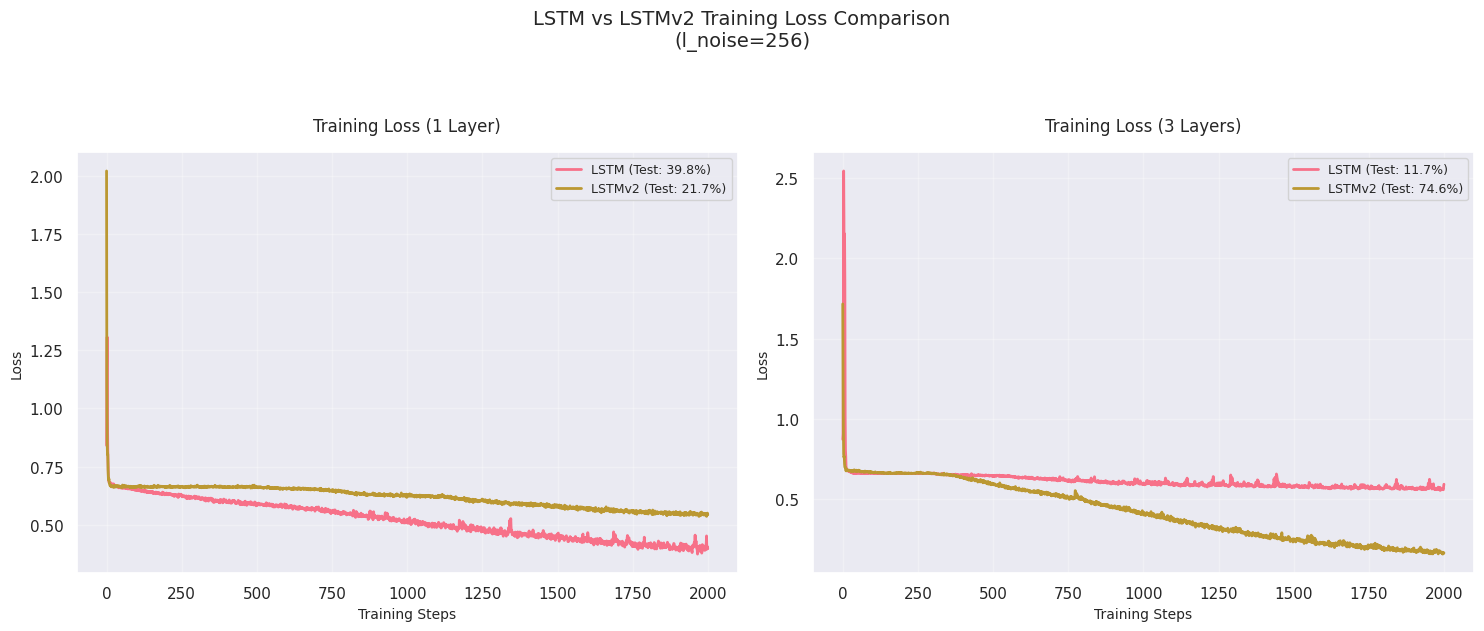

In [18]:
# Run the analysis
results = plot_training_curves()

# Print tabulated results
from tabulate import tabulate

headers = ["Model", "Layers", "Test Accuracy (%)", "Final Training Loss"]
table_data = []
for model in ["LSTM", "LSTMv2"]:
    for layers in [1, 3]:
        key = f"{model}-{layers}layer"
        table_data.append([
            model,
            layers,
            f"{results[key]['test_acc']:.2f}",
            f"{results[key]['losses'][-1]:.4f}"
        ])

print("\nPerformance Summary:")
print(tabulate(table_data, headers=headers, tablefmt="grid"))